In [26]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [49]:
# pytorch
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.distributions as td


# operations
import itertools
import pandas as pd
import time
import os

#plots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
from matplotlib.cbook import get_sample_data
from matplotlib import rcParams

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility
import detect_adversarials
from temperature_scaling import ModelWithTemperature


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


# Data Exploration and Model Setup

We first load the datasets and look at some images.

Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


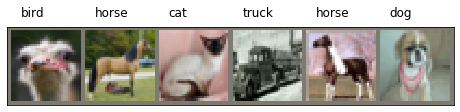

In [17]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
rcParams['figure.figsize'] = [8.0, 6.0]
visualize.display_images(inputs[:6], classes=[classes[i] for i in class_data[:6]], figurename="example1.png")

Now doing the augmentation of the images, let us illustrate it with flipping the images.

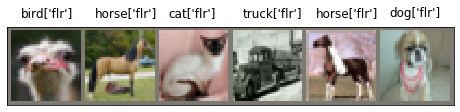

In [18]:
rcParams['figure.figsize'] = [8.0, 6.0]

aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:6], n = 1, depth = 1, augmentations="flr", flip_p=0, rot=30, br_add=40)
for i, _ in enumerate(aug_seqs_names):
    visualize.display_images(aug_batches[i], classes=[classes[j]+str(aug_seqs_names[i]) for j in class_data[:6]], figurename="example2")

Loading the pretrained ResNet model:

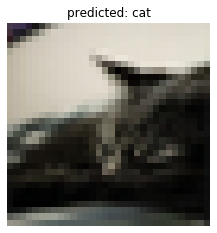

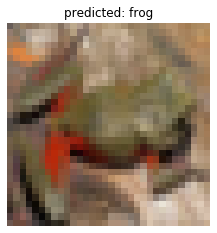

In [19]:
# load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet50.pt"
model = resnet.resnet50(pretrained=True).to(device)
# train if necessary
# model_ft = train_model.train(model, trainloader, testloader,num_epochs=2)

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=2)

Let's look at the distribution of the classes in the validation set.

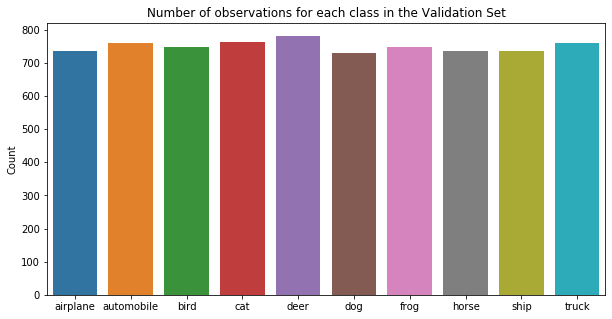

In [20]:
classes = np.array([])
for _, img_class in iter(validloader):
    classes = np.concatenate((classes,img_class.numpy()))
fig, ax = plt.subplots(figsize =(10,5))
sns.countplot(classes, ax= ax)
ax.set_title("Number of observations for each class in the Validation Set")
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels = attributes["class_names"])
ax.set_ylabel("Count")
plt.show()

And in the test set.

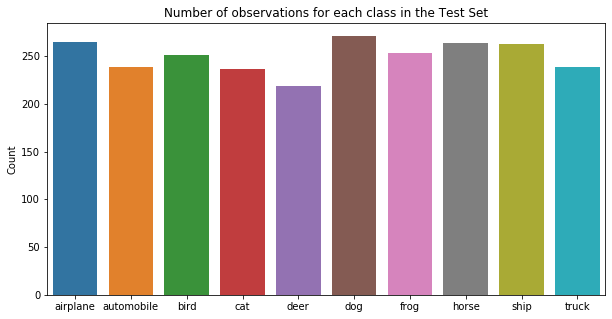

In [21]:
classes = np.array([])
for _, img_class in iter(testloader):
    classes = np.concatenate((classes,img_class.numpy()))
fig, ax = plt.subplots(figsize =(10,5))
sns.countplot(classes, ax= ax)
ax.set_title("Number of observations for each class in the Test Set")
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels = attributes["class_names"])
ax.set_ylabel("Count")
plt.show()

# Temperature Scaling

Scale the model to get correct calibration.

In [22]:
scaled_model = ModelWithTemperature(model)
structure=scaled_model.set_temperature(validloader)
temperature=structure.temperature

Before temperature - NLL: 0.256, ECE: 0.038
Optimal temperature: 1.513
After temperature - NLL: 0.209, ECE: 0.013


Do we see an improvement in the calibration of the model after the scaling?

Epsilon: 0	Test Accuracy = 7087 / 7500 = 0.9449333333333333
Expected Calibration Error: 0.038730766624212265
Epsilon: 0	Test Accuracy = 7087 / 7500 = 0.9449333333333333
Expected Calibration Error: 0.011421438306570053


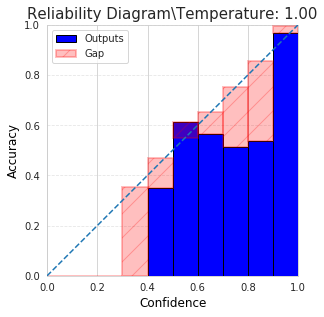

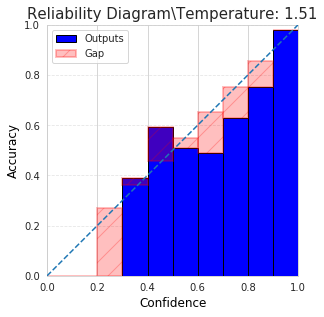

In [27]:
final_accuracy = []
temperature_test = [1, temperature.item()]
for count,i in enumerate(temperature_test):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = "none", n = 1, temperature=i)
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram\Temperature: {:.2f}".format(i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=count)
    print("Expected Calibration Error: {}".format(ece))
    #figures.append(figure)
    final_accuracy.append(final_acc)

We observe a clear improvement.

## The FGSM attack

Let us look at when it is possible for the human eye to detect an FGSM attack.

$$
\mathbf{x}^{\text{adv}} = \mathbf{\hat{x}} + \epsilon \cdot \text{sign} \nabla_{\mathbf{x}} L(\hat{\mathbf{x}}, y, \theta)
$$

In our analysis, the $\epsilon$ is the $l_{\infty}$ of the perturbation.

In [23]:
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

In [32]:
epsilon_images = []
original_images = []
l2_norms_images = []
for i in eps:
    adv_examples, original_input=FGSM.get_examples_fgsm(scaled_model, validloader, epsilon=i, limit=10)
    epsilon_images.append(adv_examples[0])
    original_images.append(original_input[0])
    diff = original_input-adv_examples
    l2_norms = torch.norm(diff.view(diff.shape[0], -1), p=2, dim=1)
    avg_l2norm = torch.mean(l2_norms, dim=0)
    l2_norms_images.append(round(l2_norms[0].item(),3))

Around $\epsilon=0.2$ it is possible to detect noise from the FGSM attack in the image

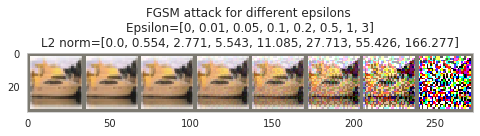

In [33]:
plt.grid(False)
visualize.imshow(epsilon_images, title="FGSM attack for different epsilons \nEpsilon="+str(eps)+"\nL2 norm="+str(l2_norms_images), savefigure="fgsm_eps")

Epsilon: 0	Test Accuracy = 7069 / 7500 = 0.9425333333333333
Majority vote accuracy.
Expected Calibration Error: 0.031062550842761993
Epsilon: 0.01	Test Accuracy = 6402 / 7500 = 0.8536
Majority vote accuracy.
Expected Calibration Error: 0.041210420429706573
Epsilon: 0.05	Test Accuracy = 4930 / 7500 = 0.6573333333333333
Majority vote accuracy.
Expected Calibration Error: 0.19992926716804504
Epsilon: 0.1	Test Accuracy = 4106 / 7500 = 0.5474666666666667
Majority vote accuracy.
Expected Calibration Error: 0.2840022146701813
Epsilon: 0.2	Test Accuracy = 3242 / 7500 = 0.4322666666666667
Majority vote accuracy.
Expected Calibration Error: 0.3652683198451996
Epsilon: 0.5	Test Accuracy = 1211 / 7500 = 0.16146666666666668
Majority vote accuracy.
Expected Calibration Error: 0.5882076621055603
Epsilon: 1	Test Accuracy = 794 / 7500 = 0.10586666666666666
Majority vote accuracy.
Expected Calibration Error: 0.6107693910598755
Epsilon: 3	Test Accuracy = 764 / 7500 = 0.10186666666666666
Majority vote acc

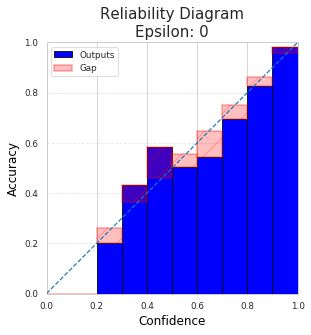

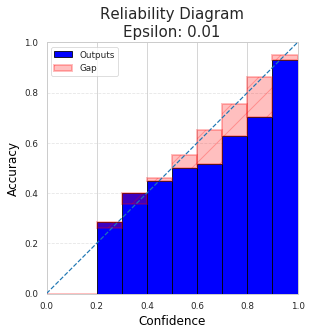

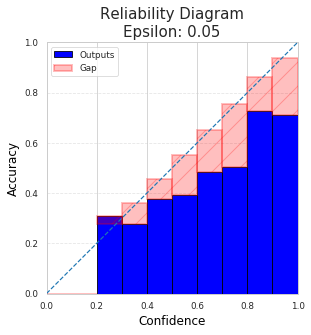

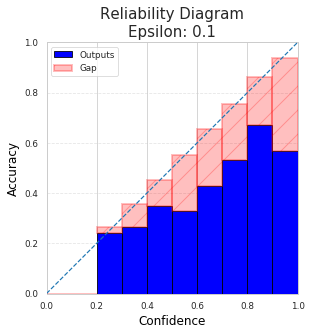

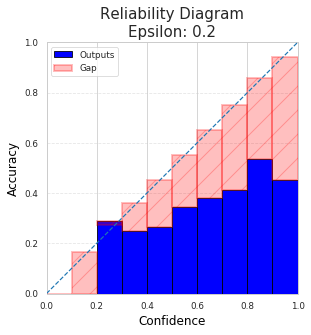

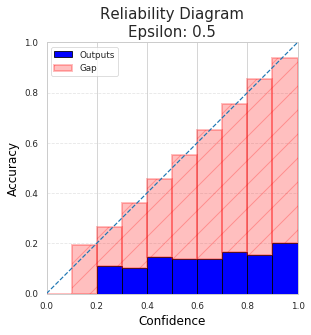

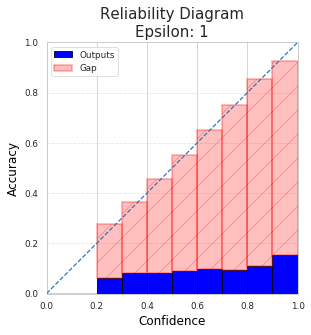

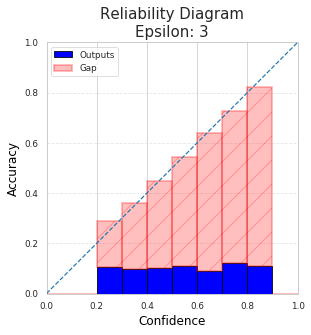

In [15]:
#### figures=[]
final_accuracy = []
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]
for count,i in enumerate(eps):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=i,
                                                                             augmentations = "none", n = 1, temperature=temperature)
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram\nEpsilon: {}".format(i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=count)
    print("Expected Calibration Error: {}".format(ece))
    #figures.append(figure)
    final_accuracy.append(final_acc)
    

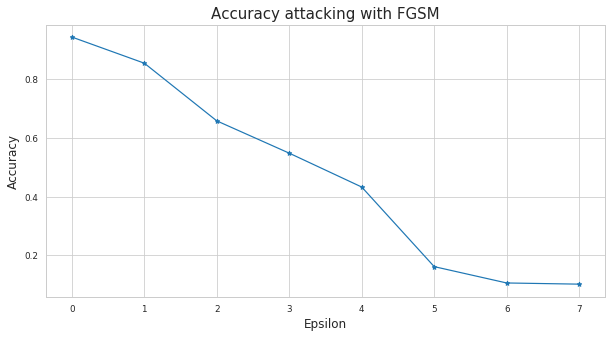

In [16]:
import seaborn as sns
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))

ax.set_title("Accuracy attacking with FGSM", fontsize=15)
ax.plot(final_accuracy, "*-")
ax.set_ylabel("Accuracy", fontsize = 12)
ax.set_xlabel("Epsilon", fontsize = 12)
plt.savefig("accuracyplot_adversaryattack.png",bbox_inches='tight',dpi=100)

We see that the accuracy gets worse and worse, but the confidence remains the same for an increasing $\epsilon$! The model needs to be calibrated.

## Introducing augmentations

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3249 / 7500 = 0.4332


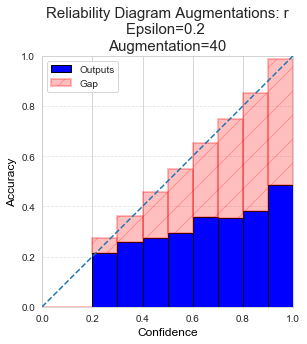

In [86]:
# the list of all augmentations to test
distinct_aug = ["r", "g","flr", "bra", "cropandpad"]
# now find all the combinations that we can create
combs = []
for r in range(1,len(distinct_aug)+1):
    combs = combs+list(itertools.combinations(distinct_aug, r))
aug_comb_list = [",".join(el) for el in combs]

n_augs = [1,2,5,10,20]
eps = [0, 0.05, 0.1, 0.2, 0.5, 1,3]
figures=[]
results = []

for aug in aug_comb_list:
    for n in n_augs:
        for epsilon in eps:
            final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
            #some statistics if necessary
            pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
            #get ece and bins
            ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
            #plot it
            if aug == "none":
                title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
            else:
                title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
            fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
            results.append({"augments":aug,"n":n,"epsilon":epsilon,"accuracy":final_acc,"ece":ece,"figure":fig})
            plt.figure(fig.number)
            plt.savefig("figures/reliability_diagram-n{}-aug{}-epsilon{}.png".format(n,aug.replace(",","-"),epsilon),bbox_inches='tight',dpi=100)
            break
            
        break
    break
    

In [ ]:
import pandas as pd
import pickle

df = pd.DataFrame(results)
df.to_pickle("results_20200409.pandaspickle")
#df.head(140)
df.to_csv("results_20200409.csv")

## Looking at invariance of augmentations

To do this the FID score is used to compare how much the different augmentations affect the model.

In [35]:
#used to illustrate examples.
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

# get model features
model_features = utility.get_features(model)

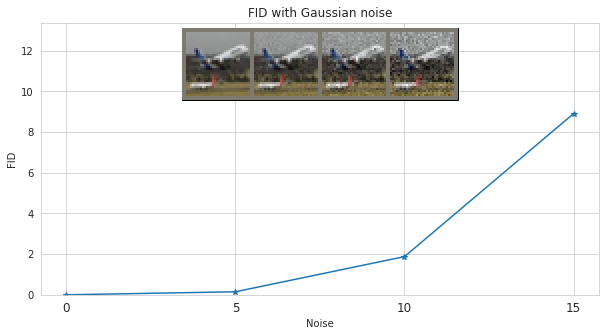

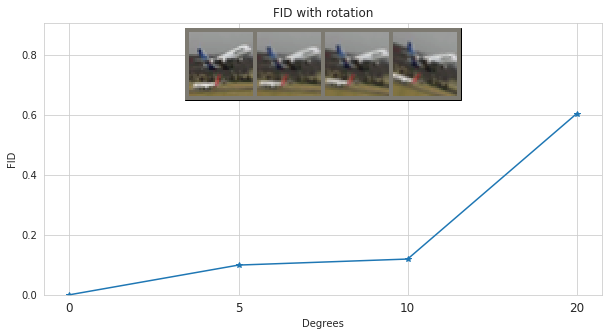

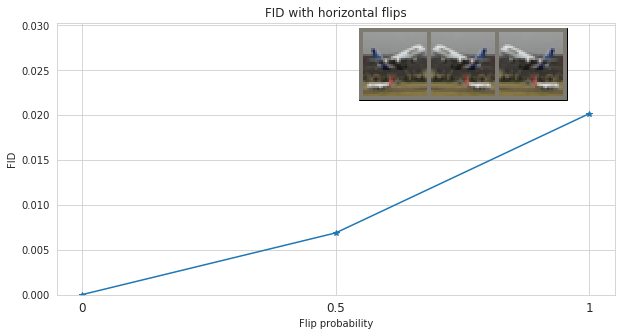

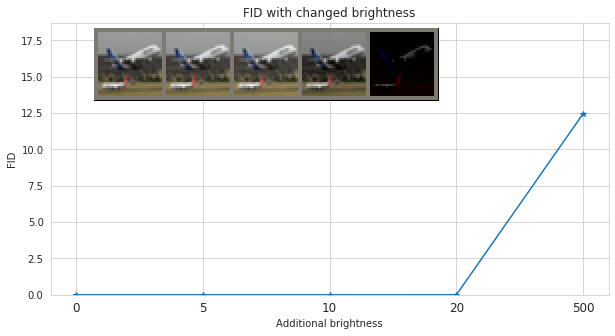

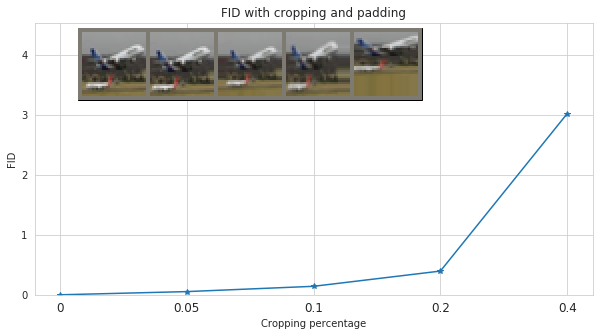

In [36]:
expansion=True
if expansion == True:
    bottleneck=True
else:
    bottleneck=False
    
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise",plot_path="gaus_aug_fid.png")

params = [0,5,10,20]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees",plot_path="rot_aug_fid.png")

params = [0,0.5,1]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="flr", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with horizontal flips", xlabel="Flip probability",plot_path="flr_aug_fid.png")

params = [0,5,50,100,200]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="bra", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with changed brightness", xlabel="Additional brightness", plot_path="bright_aug_fid.png")

params = [0,0.05,0.1,0.2, 0.4]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="cropandpad", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with cropping and padding", xlabel="Cropping percentage", plot_path="copandpad_aug_fid.png")

It is observed that the FID increases very little using augmentations such as brightness, rotation and flipping the image, indicating invariance towards these augmentations. The gaussian noise affects the model a lot. It might not be a good idea to introduce gaussian noise as a defense against adversarial attacks.

## Calibration when using augmentations

Let us look how calibration is affected when using augmentations.

We use the test set, after picking the best augmentations, to validate the performance of the model.

In [41]:
def compute_accuracy(model, dataset, namefile=None, aug="none", n=1, mode="mean"):
    final_acc, _, pred_log_probs, target_labels = FGSM.test_augmented(model, dataset, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = aug, n = n);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, n: {}".format(i, 0, n)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"aug")
    print("Expected Calibration Error: {}".format(ece))
    if namefile is None:
        plt.savefig("figures/"+"reliability_diagram_"+str(count)+"aug"+".png",bbox_inches='tight',dpi=100)
    else:
        plt.savefig("figures/"+str(namefile),bbox_inches='tight',dpi=100)
    return figure

In [3]:
figures=[]

n=1
augs = ["cropandpad", "flr", "r"]
for count,i in enumerate(augs):
    print(count, i)
    figure = compute_accuracy(scaled_model, testloader, namefile="reliability_diagram_{}_{}.png".format(count,i), aug=i, n=10)
    figures.append(figure)

0 cropandpad


NameError: name 'compute_accuracy' is not defined

## Robustness

Measure robustness with different augmentations. On the test set, with the chosen augmentations.

In [1]:
import FGSM

In [4]:
n = 1
l_inf_norms = []
for count,i in enumerate(augs):
    print(count,i)
    l_inf_norm = FGSM.measure_robustness(scaled_model, testloader,n=n, depth=1, augmentations=i, v=1)
    l_inf_norms.append(l_inf_norm)

0 cropandpad


NameError: name 'scaled_model' is not defined

## Detecting errors

Collect samples rom each class, to get unbiased results.

In [19]:
good_adversarials = detect_adversarials.get_good_adversarial(scaled_model, testloader, epsilon= 0.3, N = 100)

In [20]:
samples_correct = detect_adversarials.get_samples_from_classes(scaled_model, testloader, 100)

In [21]:
samples_missclass = detect_adversarials.get_samples_from_classes(scaled_model, testloader, 100, missclass = True)

To compute the $D_{KL}$ we use the Pytorch analytical KL divergence between categorical variables.

In [22]:
def get_l1_norm__augmentations(model, datalist, augmentations, n):
    l1_norms = []
    for data in datalist:
        data = data.view(1, 3, 32, 32).to(device)
        # only one augmentation at a time
        assert len(augmentations.split(",")) >= 1
        augmented_batch, _, _ = augment.compute_augmentations(data.detach().cpu(),
                                                              n=n, depth=1, augmentations=augmentations, flip_p=1,
                                                              rot=(-15, -14.9))

        for i in range(n):
            data = torch.cat((data, augmented_batch[i].to(device)), 0)
        # concatenate the true image and the augmented image
        output = F.log_softmax(model(data), dim=1)

        init_pred = output[0].exp()
        aug_pred = torch.mean(output[1:].exp(), dim=0)

        l1_norms.append(torch.norm(init_pred-aug_pred, p=1).item())

    return l1_norms

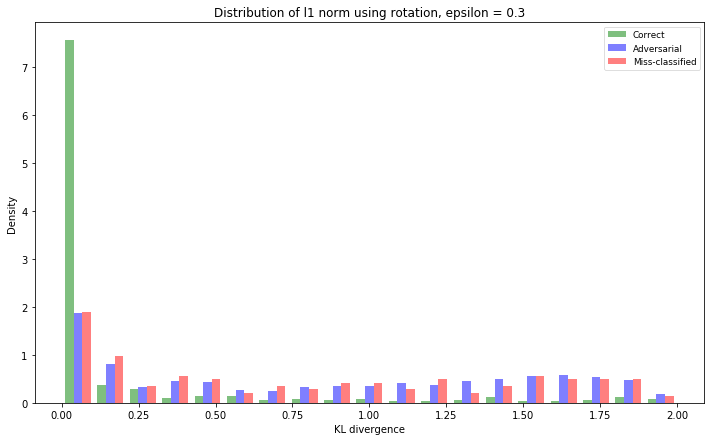

In [23]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = get_l1_norm__augmentations(scaled_model,samples_correct_list, "r", 5)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_l1_norm__augmentations(scaled_model,samples_miss_list, "r", 5)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_l1_norm__augmentations(scaled_model,samples_adv_list, "r", 5)

fig,ax = plt.subplots(figsize = (12,7))
ax.set_title("Distribution of l1 norm using rotation, epsilon = {}".format(0.3))
sns.set_context("paper")
plt.hist([kl_div_correct_r_1,kl_div_adv_r_1, kl_div_missclass_r_1,],bins = list(np.linspace(0,2,20)), color=['g','b','r'],density=True, alpha=0.5, label = ["Correct", "Adversarial", "Miss-classified"])
ax.set_xlabel("KL divergence")
ax.set_ylabel("Density")
ax.legend()

In [ ]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = detect_adversarials.get_kl_augmentations(scaled_model,samples_correct_list, "r", 1)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_kl_augmentations(scaled_model,samples_miss_list, "r", 1)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_kl_augmentations(scaled_model,samples_adv_list, "r", 1)

In [ ]:
augmentations = [("rotation", "r"), ("horizontal flip", "fliplr")]
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

cur_aug = "rotation"
cur_eps = 0.3
kl_div_correct = {}
kl_div_missclass = {}
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]


for cur_augs in augmentations:
    kl_div_missclass[cur_augs[1]] = get_kl_augmentations(scaled_model,samples_miss_list, cur_augs[1], 1)
    kl_div_correct[cur_augs[1]] = get_kl_augmentations(scaled_model,samples_correct_list, cur_augs[1], 1)
    
for cur_eps in epsilons:
    good_adversarials = get_good_adversarial(model, testloader, epsilon= cur_eps, N = 100)
    samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
    for cur_augs in augmentations:
        
        kl_div_adv_r_1 = get_kl_augmentations(scaled_model,samples_adv_list, cur_augs[1], 1)
        
        sns.set_context("paper")
        fig,ax = plt.subplots(figsize = (7,7))
        ax.set_title("Distribution of KL divergence using {}, epsilon = {}".format(cur_augs[0], cur_eps))
        hist_errorbars(kl_div_correct[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#55A868", label="Correct")
        hist_errorbars(kl_div_missclass[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#C44E52", label="Miss-classified")
        hist_errorbars(kl_div_adv_r_1,normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#4C72B0", label="Adversarial")

        ax.grid(alpha = 0.2)
        ax.set_xlabel("KL divergence")
        ax.set_ylabel("Density")
        plt.legend()
        plt.show()
        plt.pause(0.01)